In [2]:
#Install all the Reqiuired Libraries and Packages 
import os
import glob
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc , logfbank
import librosa as lr
import os, glob, pickle
import librosa
from scipy import signal
import noisereduce as nr
from glob import glob
import librosa
#All the Required Packages and Libraies are installed.
import soundfile
from tensorflow.python.keras.layers import Conv2D,MaxPool2D, Flatten, LSTM
from keras.layers import Dropout,Dense,TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical 
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [20]:
#Loading the required RAVDESS DataSet with length of 1439 Audio Files 
os.listdir(path='F:/VS Code/Minor1_midsem/speech-emotion-recognition-ravdess-data')
def getListOfFiles(dirName):
    listOfFile=os.listdir(dirName)
    allFiles=list()
    for entry in listOfFile:
        fullPath=os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles=allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
    return allFiles

dirName = './speech-emotion-recognition-ravdess-data'
listOfFiles = getListOfFiles(dirName)
len(listOfFiles)

1439

In [ ]:
#Use the Speech-Recognition API to get the Raw Text from Audio Files, Though Speech Recognition
#is less strong for large chunk of files , so used Error Handling , where when it is not be able to 
#produce the text of a particular Audio File it prints the statement 'error'.Just for understanding Audio
import speech_recognition as sr
r=sr.Recognizer()
for file in range(0 , len(listOfFiles) , 1):
    with sr.AudioFile(listOfFiles[file]) as source:
        audio = r.listen(source)
        try:
            text = r.recognize_google(audio)
            print(text)
        except:
            print('error')

is it talking by the door
dog sitting by the door
talk to Siri why the door
error
error
error
dog sitting by the door
change your talking by the door
kids talking by the door
dogs sitting by the door
sitting by the
kids talking by the door
talking by the door
dog sitting by the door
error
talking by the door
error
sitting by the door
error
kids talking by the door
khesa talking by the door
error
error
kids talking by the door
talking by the door
dogs sitting by the door
sitting by the door
talking by the door
is a talking by the door
the door
error
the door
Earth talking by the door
frogs are sitting by the door
dogs are sitting at the door
talking by the door
kids talking by the door
dogs sitting by the door
dogs sitting by the door
f****** by the door
is the talking to the door
Rockstar ceiling by the door
ceiling by the
error
khinch
sitting by the door
coronavirus
kids talking by the door
talking by the door
tour tour
exit the door
kids talking
kids talking by the door
dogs sitting 

In [21]:
#Now Cleaning Step is Performed where:
#DOWN SAMPLING OF AUDIO FILES IS DONE  AND PUT MASK OVER IT AND DIRECT INTO CLEAN FOLDER
#MASK IS TO REMOVE UNNECESSARY EMPTY VOIVES AROUND THE MAIN AUDIO VOICE 
def envelope(y , rate, threshold):
    mask=[]
    y=pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10) ,  min_periods=1 , center = True).mean()
    for mean in y_mean:
        if mean>threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [ ]:
#Plotting the Basic Graphs for understanding of Audio Files :
for file in range(0 , len(listOfFiles) , 1):
    audio , sfreq = lr.load(listOfFiles[file])
    time = np.arange(0 , len(audio)) / sfreq
    
    fig ,ax = plt.subplots()
    ax.plot(time , audio)
    ax.set(xlabel = 'Time (s)' , ylabel = 'Sound Amplitude')
    plt.show()
    
#PLOT THE SEPCTOGRAM
for file in range(0 , len(listOfFiles) , 1):
     sample_rate , samples = wavfile.read(listOfFiles[file])
     frequencies , times, spectrogram = signal.spectrogram(samples, sample_rate) 
     plt.pcolormesh(times, frequencies, spectrogram)
     plt.imshow(spectrogram)
     plt.ylabel('Frequency [Hz]')
     plt.xlabel('Time [sec]')
     plt.show()

In [ ]:
#Next Step is In-Depth Visualisation of Audio Fiels and its certain features to plot for.
#They are the Plotting Functions to be called later. 
def plot_signals(signals):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Time Series' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1

def plot_fft(fft):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transform' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            data = list(fft.values())[i]
            Y,freq = data[0] , data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq , Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1
    
def plot_fbank(fbank):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],cmap='hot', interpolation = 'nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1
            
def plot_mfccs(mfccs):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Capstrum  Coefficients' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                             cmap='hot', interpolation = 'nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1

def calc_fft(y,rate):
    n = len(y)
    freq = np.fft.rfftfreq(n , d= 1/rate)
    Y= abs(np.fft.rfft(y)/n)
    return(Y,freq)

In [ ]:
# Here The Data Set is loaded and plots are Visualised by Calling the Plotting Functions . 
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from scipy.fftpack import fft
import numpy as np
for file in range(0 , len(listOfFiles) , 1):
    rate, data = wav.read(listOfFiles[file])
    fft_out = fft(data)
    %matplotlib inline
    plt.plot(data, np.abs(fft_out))
    plt.show()
    
signals={}
fft={}
fbank={}
mfccs={}
# load data
for file in range(0 , len(listOfFiles) , 1):
#     rate, data = wavfile.read(listOfFiles[file])
     signal,rate =librosa.load(listOfFiles[file] , sr=44100)
     mask = envelope(signal , rate , 0.0005)
     signals[file] = signal
     fft[file] = calc_fft(signal , rate)
    
     bank = logfbank(signal[:rate] , rate , nfilt = 26, nfft = 1103).T
     fbank[file] = bank
     mel = mfcc(signal[:rate] , rate , numcep =13 , nfilt = 26 , nfft=1103).T
     mfccs[file]=mel

plot_signals(signals)
plt.show()

plot_fft(fft)
plt.show()

plot_fbank(fbank)
plt.show()

plot_mfccs(mfccs)
plt.show()

In [22]:
#Now Cleaning Step is Performed where:
#DOWN SAMPLING OF AUDIO FILES IS DONE  AND PUT MASK OVER IT AND DIRECT INTO CLEAN FOLDER
#MASK IS TO REMOVE UNNECESSARY EMPTY VOIVES AROUND THE MAIN AUDIO VOICE 
def envelope(y , rate, threshold):
    mask=[]
    y=pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10) ,  min_periods=1 , center = True).mean()
    for mean in y_mean:
        if mean>threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [23]:
#The clean Audio Files are redirected to Clean Audio Folder Directory 
import glob,pickle
for file in tqdm(glob.glob(r'F:\VS Code\Minor1_midsem\speech-emotion-recognition-ravdess-data\\**\\*.wav')):
    file_name = os.path.basename(file)
    signal , rate = librosa.load(file, sr=16000)
    mask = envelope(signal,rate, 0.0005)
    wavfile.write(filename= r'F:\VS Code\Minor1_midsem\clean_ravdess\\'+str(file_name), rate=rate,data=signal[mask])

100%|██████████| 1439/1439 [00:20<00:00, 71.79it/s]


In [24]:
#Feature Extraction of Audio Files Function 
#Extract features (mfcc, chroma, mel) from a sound file
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
        result=np.hstack((result, mel))
    return result

In [36]:
#Emotions in the RAVDESS dataset to be classified Audio Files based on . 
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
#These are the emotions User wants to observe more :
observed_emotions=['calm', 'happy', 'fearful', 'disgust']

In [37]:
#Load the data and extract features for each sound file
from glob import glob
import os
import glob
def load_data(test_size=0.33):
    x,y=[],[]
    answer = 0
    for file in glob.glob(r'F:\VS Code\Minor1_midsem\clean_ravdess\\*.wav'):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            answer += 1
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append([emotion,file_name])
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [38]:
#Split the dataset
import librosa
import numpy as np
x_train,x_test,y_train,y_test=load_data(test_size=0.25)
print(np.shape(x_train),np.shape(x_test), np.shape(y_train),np.shape(y_test))
y_test_map = np.array(y_test).T
y_test = y_test_map[0]
test_filename = y_test_map[1]
y_train_map = np.array(y_train).T
y_train = y_train_map[0]
train_filename = y_train_map[1]
print(np.shape(y_train),np.shape(y_test))
print(*test_filename,sep="\n")

C:\Users\dell\AppData\Local\Temp\ipykernel_17820\2946855648.py:17: FutureWarning: Pass y=[-0.00137329  0.00024414  0.00015259 ... -0.0005188  -0.00079346
 -0.00091553] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
C:\Users\dell\AppData\Local\Temp\ipykernel_17820\2946855648.py:17: FutureWarning: Pass y=[ 1.2207031e-04  6.1035156e-05  9.1552734e-05 ... -1.0986328e-03
 -1.0681152e-03 -1.0375977e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
C:\Users\dell\AppData\Local\Temp\ipykernel_17820\2946855648.py:17: FutureWarning: Pass y=[ 3.0517578e-05  6.1035156e-05  6.1035156e-05 ... -3.0517578e-05
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel=np.mean(librosa

(576, 180) (192, 180) (576, 2) (192, 2)
(576,) (192,)
03-01-06-01-02-02-01.wav
03-01-03-01-02-01-21.wav
03-01-07-01-02-02-04.wav
03-01-02-02-01-02-24.wav
03-01-07-01-02-02-19.wav
03-01-06-01-01-01-07.wav
03-01-07-01-01-01-16.wav
03-01-02-01-02-02-06.wav
03-01-06-01-01-02-07.wav
03-01-06-02-01-01-15.wav
03-01-02-02-02-02-07.wav
03-01-06-01-02-02-19.wav
03-01-06-02-02-02-05.wav
03-01-06-01-01-01-14.wav
03-01-06-01-02-01-15.wav
03-01-03-02-02-01-06.wav
03-01-02-01-01-02-16.wav
03-01-07-01-01-01-13.wav
03-01-03-02-02-02-24.wav
03-01-02-01-02-02-19.wav
03-01-02-02-01-02-09.wav
03-01-02-01-01-02-07.wav
03-01-03-01-02-01-13.wav
03-01-02-01-02-01-18.wav
03-01-02-02-02-02-03.wav
03-01-02-02-01-01-11.wav
03-01-03-01-02-02-20.wav
03-01-03-02-01-02-06.wav
03-01-06-01-01-02-11.wav
03-01-03-01-02-01-18.wav
03-01-06-01-01-01-15.wav
03-01-07-02-01-02-08.wav
03-01-07-02-01-02-23.wav
03-01-03-01-02-02-10.wav
03-01-06-01-01-01-23.wav
03-01-07-02-02-01-18.wav
03-01-06-02-02-01-22.wav
03-01-07-02-01-01-21.

C:\Users\dell\AppData\Local\Temp\ipykernel_17820\2946855648.py:17: FutureWarning: Pass y=[-0.00045776  0.00057983  0.00073242 ...  0.00076294  0.00061035
  0.00057983] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
C:\Users\dell\AppData\Local\Temp\ipykernel_17820\2946855648.py:17: FutureWarning: Pass y=[ 3.0517578e-05  0.0000000e+00  3.0517578e-05 ... -4.2724609e-04
 -4.5776367e-04 -5.1879883e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
C:\Users\dell\AppData\Local\Temp\ipykernel_17820\2946855648.py:17: FutureWarning: Pass y=[-0.0007019  -0.00064087 -0.00061035 ...  0.00054932  0.00057983
  0.00064087] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel=np.mean(librosa.feature.melspectr

In [39]:
#Get the shape of the training and testing datasets
print((x_train.shape[0], x_test.shape[0]))
print((x_train[0], x_test[0]))
#Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

(576, 192)
(array([-4.72596130e+02,  6.36280098e+01,  6.51110840e+00,  2.24857616e+01,
       -1.83761387e+01, -8.53219795e+00, -7.86483955e+00, -2.94664574e+00,
       -4.15714836e+00,  9.12407303e+00, -1.22783113e+00, -4.30203199e+00,
       -6.14194751e-01,  1.26341581e+00, -7.18617582e+00, -4.65811789e-01,
       -5.67236376e+00, -4.63177353e-01, -6.48498106e+00, -5.87361145e+00,
       -4.74468756e+00, -1.75936961e+00, -4.87984037e+00, -1.12982118e+00,
       -8.85937309e+00,  5.06445265e+00, -2.07698917e+00,  6.41565740e-01,
       -2.19691277e+00, -1.91285634e+00,  2.47950718e-01, -4.24820594e-02,
       -5.15642500e+00, -4.49983644e+00, -7.80279922e+00, -3.86615586e+00,
       -6.02821112e-01, -1.82930505e+00, -5.03239822e+00, -4.90249920e+00,
        6.34551942e-01,  6.20559394e-01,  6.65639400e-01,  6.81318283e-01,
        7.40016043e-01,  7.67469287e-01,  7.01811910e-01,  6.61603928e-01,
        7.28583276e-01,  6.82222605e-01,  6.39337242e-01,  6.59504592e-01,
        3.142

In [40]:

# Initialize the Multi Layer Perceptron Classifie
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [41]:
#Train the model
model.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [42]:

#SAVING THE MODEL
import pickle
# Save the Modle to file in the current working directory
#For any new testing data other than the data in dataset

Pkl_Filename = "F:/VS Code/Minor1_midsem/Emotion_Voice_Detection_Model1.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model, file)

In [43]:
# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    Emotion_Voice_Detection_Model = pickle.load(file)

Emotion_Voice_Detection_Model

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [44]:
#predicting :
y_pred=Emotion_Voice_Detection_Model.predict(x_test)
y_pred

array(['fearful', 'happy', 'happy', 'calm', 'disgust', 'calm', 'disgust',
       'calm', 'happy', 'fearful', 'calm', 'fearful', 'happy', 'fearful',
       'fearful', 'happy', 'calm', 'disgust', 'fearful', 'calm', 'calm',
       'calm', 'happy', 'calm', 'calm', 'calm', 'fearful', 'happy',
       'disgust', 'calm', 'fearful', 'disgust', 'disgust', 'happy',
       'fearful', 'disgust', 'fearful', 'disgust', 'happy', 'fearful',
       'disgust', 'calm', 'happy', 'fearful', 'fearful', 'calm',
       'fearful', 'disgust', 'calm', 'calm', 'happy', 'happy', 'happy',
       'disgust', 'disgust', 'disgust', 'happy', 'calm', 'happy', 'calm',
       'disgust', 'happy', 'disgust', 'fearful', 'calm', 'happy', 'calm',
       'happy', 'fearful', 'fearful', 'disgust', 'calm', 'calm', 'calm',
       'disgust', 'calm', 'disgust', 'happy', 'happy', 'disgust', 'happy',
       'happy', 'happy', 'fearful', 'disgust', 'fearful', 'disgust',
       'fearful', 'disgust', 'fearful', 'calm', 'happy', 'happy', 'hap

In [45]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
result = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(result)
print('Accuracy Score :',accuracy_score(y_test, y_pred))
print('Report : ')
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[48  3  1  2]
 [ 2 36  2  4]
 [ 2  5 39  7]
 [ 1  2  3 35]]
Accuracy Score : 0.8229166666666666
Report : 
              precision    recall  f1-score   support

        calm       0.91      0.89      0.90        54
     disgust       0.78      0.82      0.80        44
     fearful       0.87      0.74      0.80        53
       happy       0.73      0.85      0.79        41

    accuracy                           0.82       192
   macro avg       0.82      0.82      0.82       192
weighted avg       0.83      0.82      0.82       192



In [46]:
#Store the Prediction probabilities into CSV file 
import numpy as np
import pandas as pd
y_pred1 = pd.DataFrame(y_pred, columns=['predictions'])
y_pred1['file_names'] = test_filename
print(y_pred1)
y_pred1.to_csv('predictionfinal1.csv')

    predictions                file_names
0       fearful  03-01-06-01-02-02-01.wav
1         happy  03-01-03-01-02-01-21.wav
2         happy  03-01-07-01-02-02-04.wav
3          calm  03-01-02-02-01-02-24.wav
4       disgust  03-01-07-01-02-02-19.wav
..          ...                       ...
187     disgust  03-01-07-01-02-02-14.wav
188       happy  03-01-03-02-02-02-02.wav
189     fearful  03-01-06-02-01-01-14.wav
190     disgust  03-01-07-01-01-02-02.wav
191        calm  03-01-02-02-02-01-22.wav

[192 rows x 2 columns]


In [ ]:
#RECORDED USING MICROPHONE:
import pyaudio
import wave

CHUNK = 1024 
FORMAT = pyaudio.paInt16 #paInt8
CHANNELS = 2 
RATE = 44100 #sample rate
RECORD_SECONDS = 4
WAVE_OUTPUT_FILENAME = "output1.wav"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK) #buffer

print("* recording")
frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data) # 2 bytes(16 bits) per channel

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

* recording
* done recording


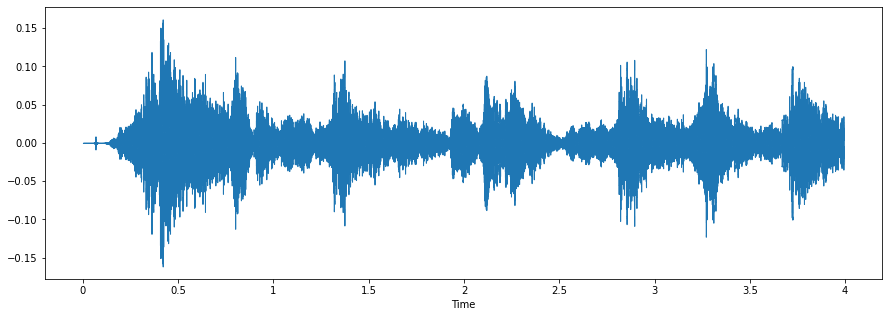

In [ ]:
#The file 'output10.wav' in the next cell is the file that was recorded live using the code :
data, sampling_rate = librosa.load('output1.wav')
%matplotlib inline
import os
import pandas as pd
import librosa.display
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

In [ ]:
## Appying extract_feature function on random file and then loading model to predict the result 
file = 'F:/VS Code/Minor1_midsem/output1.wav'
signal , rate = librosa.load(file, sr=16000)
mask = envelope(signal,rate, 0.0005)
wavfile.write(filename= r'F:\VS Code\Minor1_midsem\cleaned2.wav', rate=rate,data=signal[mask])


In [48]:
file1 = 'F:/VS Code/Minor1_midsem/cleaned.wav'
'''data , sr = librosa.load(file1)
data = np.array(data)'''
ans =[]
new_feature = extract_feature(file1, mfcc=True, chroma=True, mel=True)
ans.append(new_feature)
ans = np.array(ans)
# data.shape

Emotion_Voice_Detection_Model.predict(ans)

C:\Users\dell\AppData\Local\Temp\ipykernel_17820\2946855648.py:17: FutureWarning: Pass y=[-3.8703398e-05 -3.6789566e-05 -2.5378515e-05 ...  4.3817732e-02
  7.6810025e-02  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)


array(['fearful'], dtype='<U7')